# Introduction

This notebook shows a OCR model built with [Keras](https://keras.io/) functional API. CNN and RNN are combined and a new layer is instantiated and used as an "endpoint layer" to implement CTC loss.

The [dataset](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images) contains 1040 captcha files as png images and 30 captcha files as jpg images. The label for each sample is a string, the name of the file (minus the file format). The images are 5 letter words and have noise applied (blur and lines). The images are of size 200 x 50.

# Setup environment

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=1fd77ec5649af6305f618d6b07e98a62d0e3fd86edf6ef3ca09f1bb54ad6092f
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
import pyspark as ps
import timeit
import time
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from pathlib import Path

In [ ]:
#sc = ps.SparkContext.getOrCreate('local[*]')
sc = ps.SparkContext('local[*]')

In [ ]:
drive.mount('/content/drive/')
path = 'drive/My Drive/samples'

Mounted at /content/drive/


In [ ]:
print('Tensorflow version:', tf.__version__)

gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at:', gpu_device_name)

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

cpu()
gpu()

print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print('CPU (s):', cpu_time)
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print('GPU (s):', gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Tensorflow version: 2.12.0
Found GPU at: /device:GPU:0
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s): 4.737662132999958
GPU (s): 0.08734729399998287
GPU speedup over CPU: 54x


# Data exploration

In [ ]:
data_dir = Path(path)
images = list(data_dir.glob('*.*'))
print('Images found: {}\n'.format(len(images)))

chars_and_numbers = []
dataset = []
for i in images:
    chars_and_numbers.append([*i.stem])
    split = i.name.split('.')
    label = split[0]
    format = split[1]
    dataset.append((str(i), label, format))

captcha_rdd = sc.parallelize(chars_and_numbers).flatMap(lambda xs: [x[0] for x in xs]).map(
                                                        lambda x: (x, 1)).reduceByKey(
                                                        lambda x,y: x + y)

chars_count = 0
char_set = set()
numbers_count= 0
number_set = set()
for i in captcha_rdd.collect():
    key = i[0]
    value = i[1]
    if key.isnumeric():
        numbers_count += value
        number_set.add(key)
    else:
        chars_count += value
        char_set.add(key)

print('Characters found:', chars_count)
print('Unique characters found: {}\n'.format(len(char_set)))
print('Numbers found:', numbers_count)
print('Unique numbers found: {}\n'.format(len(number_set)))

df = pd.DataFrame(dataset, columns=['path', 'label', 'format'], index=None)
df.head()

Images found: 1070

Characters found: 3431
Unique characters found: 12

Numbers found: 1919
Unique numbers found: 7



,path,label,format
0,drive/My Drive/samples/4egem.png,4egem,png
1,drive/My Drive/samples/4exnn.png,4exnn,png
2,drive/My Drive/samples/4fc36.png,4fc36,png
3,drive/My Drive/samples/4f8yp.png,4f8yp,png
4,drive/My Drive/samples/4fp5g.png,4fp5g,png


# Data visualization

In [ ]:
df2 = df.groupby(['format']).count().reset_index()
df2.columns.values[0] = 'Format'
df2.columns.values[1] = 'Count'
df2 = df2[['Format', 'Count']]

fig = px.pie(df2,
             values='Count',
             names='Format',
             title='Image formats percentage',
             color_discrete_sequence=px.colors.sequential.Darkmint)
fig.show()

In [ ]:
fig = px.bar(pd.DataFrame(captcha_rdd.filter(lambda x: x[0].isalpha()).collect()).set_index(0).sort_values(by=1, ascending=False),
       labels={'value': 'Count'},
       color='value',
       color_continuous_scale='tempo',
       text_auto=True)
fig.update_layout(xaxis_title='Characters')
fig.show()

In [ ]:
fig = px.bar(pd.DataFrame(captcha_rdd.filter(lambda x: x[0].isnumeric()).collect()).set_index(0).sort_values(by=1, ascending=False),
       labels={'value': 'Count'},
       color='value',
       color_continuous_scale='tempo',
       text_auto=True)
fig.update_layout(xaxis_title='Numbers')
fig.show()

# Data loading and preprocessing

In [ ]:
images = sorted(sc.parallelize(list(map(str, list(Path(path).glob('*.*'))))).filter(
    lambda x: len(x.split('.')) == 2).filter(
    lambda x: x.split('.')[1] in ['jpg', 'png']).collect())
labels = [img.split(os.path.sep)[-1].split('.')[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

batch_size = 16
img_width = 200
img_height = 50
max_length = max([len(label) for label in labels])

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    return {'image': img, 'label': label}

Each character in the string is mapped to an integer for training the model. Similarly, model predictions are mapped back to strings. For this purpose, two dictionaries are maintained, in order to map characters to integers and integers to characters, respectively.

In [ ]:
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# Create train set and validation set

In [ ]:
def split_data(images, labels, train_size, shuffle):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels), 0.9, True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

# Visualize images

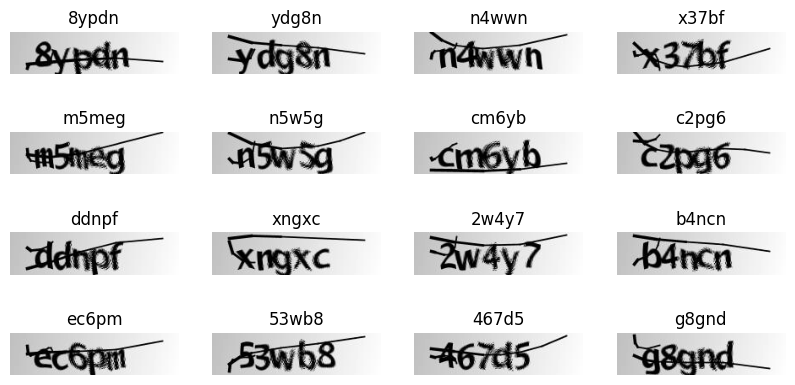

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']
    for i in range(16):
        img = (batch_images[i] * 255).numpy().astype('uint8')
        label = tf.strings.reduce_join(num_to_char(batch_labels[i])).numpy().decode('UTF-8')
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis('off')
plt.show()

# Create model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [ ]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name='image', dtype='float32')
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    x = layers.Conv2D(
        16,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv3',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool3')(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2')(x)

    output = CTCLayer(name='ctc_loss')(labels, x)

    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name='ocr_model_v1')
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

In [ ]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv2 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool2 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv2[0][0]']                  
                                                                                                  
 Conv3 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool2[0][0]']       

# Train model

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
time_callback = TimeHistory()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    callbacks=[time_callback],
    epochs=100
)
times = time_callback.times

Epoch 1/100
61/61 [==============================] - 19s 78ms/step - loss: 20.3677 - val_loss: 16.3499
Epoch 2/100
61/61 [==============================] - 3s 47ms/step - loss: 16.3686 - val_loss: 16.3566
Epoch 3/100
61/61 [==============================] - 4s 70ms/step - loss: 16.3522 - val_loss: 16.3674
Epoch 4/100
61/61 [==============================] - 3s 46ms/step - loss: 16.3410 - val_loss: 16.3666
Epoch 5/100
61/61 [==============================] - 3s 47ms/step - loss: 16.3235 - val_loss: 16.3359
Epoch 6/100
61/61 [==============================] - 3s 54ms/step - loss: 16.3025 - val_loss: 16.3382
Epoch 7/100
61/61 [==============================] - 3s 49ms/step - loss: 16.2754 - val_loss: 16.2668
Epoch 8/100
61/61 [==============================] - 3s 46ms/step - loss: 16.2087 - val_loss: 16.2492
Epoch 9/100
61/61 [==============================] - 4s 59ms/step - loss: 16.1466 - val_loss: 16.1452
Epoch 10/100
61/61 [==============================] - 5s 88ms/step - loss: 16.072

In [ ]:
seconds = sc.parallelize(times).reduce(lambda x, y: x + y)
print('Time (s) to train the model:', datetime.timedelta(seconds=seconds))

Time (s) to train the model: 0:05:51.225748


Text(0.5, 1.0, 'Loss function')

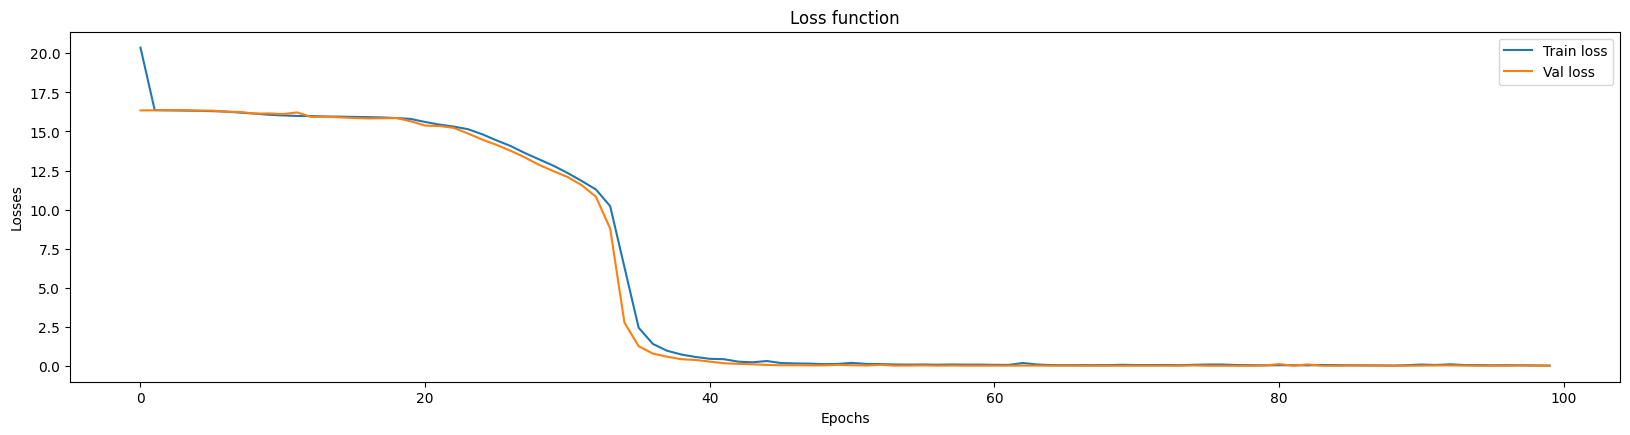

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train loss','Val loss'])
plt.title('Loss function')

# Save model

In [ ]:
model_path = 'drive/My Drive/model/model.keras'

In [ ]:
model.save(model_path, overwrite=False)

[WARNING] drive/My Drive/model/model.keras already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!


# Inference

In [ ]:
# Load the model saved on Drive
custom_objects = {'CTCLayer': CTCLayer}
with keras.utils.custom_object_scope(custom_objects):
    loaded_model = tf.keras.models.load_model(model_path)

prediction_model = keras.models.Model(loaded_model.get_layer(name='image').input, loaded_model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv2 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool2 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv3 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool3 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

1/1 [==============================] - 0s 39ms/step


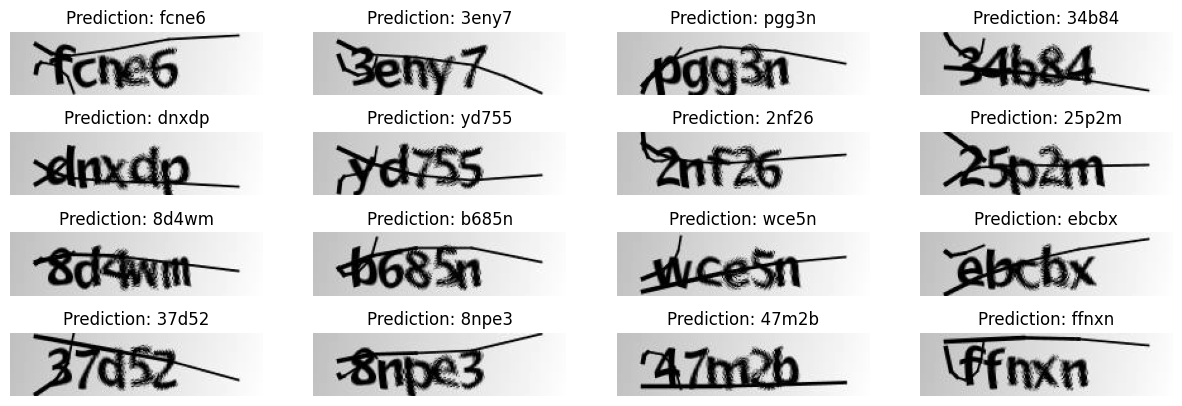

In [ ]:
for batch in validation_dataset.take(1):
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = 'Prediction: {}'.format(pred_texts[i])
        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis('off')

plt.show()

# Accuracy

In [ ]:
def plot_accuracy(successes, failures):
    print('Predicted captchas:', successes + failures)
    print('Correct predictions:', successes)
    print('Incorrect predictions:', failures)
    print('')
    px.pie(pd.DataFrame({'names': ['Successes', 'Failures'], 'values': [successes, failures]}),
           values='values',
           names='names',
           title='Success/Failure rate',
           color_discrete_sequence=['#00cc96', '#ef553b']).show()

In [ ]:
def get_img_path(path, format, label):
  if path is not None and format is not None:
    return path + '/' + label + '.' + format
  return df[df['label'] == label].iloc[0][0]

def plot_wrong_predictions(path, format, prediction_list):
    for i in prediction_list:
        print('Wrong prediction:', i[0])
        print('Actual text:', i[1])
        img_path = get_img_path(path, format, i[1])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_AREA)
        plt.imshow(img, 'gray')
        plt.axis('off')
        plt.show()
        print('')

In [ ]:
def encode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    return img

## Validation set

In [ ]:
successes = 0
failures = 0
wrong_predictions = []

for batch in validation_dataset:
    batch_images = batch['image']
    batch_labels = batch['label']

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')
        orig_texts.append(label)

    for i in range(len(pred_texts)):
        predicted_value = str(pred_texts[i])
        label = str(orig_texts[i])
        if predicted_value == str(orig_texts[i]):
            successes += 1
        else:
            wrong_predictions.append((predicted_value, label))
            failures += 1

plot_accuracy(successes, failures)
print('')
plot_wrong_predictions(None, None, wrong_predictions)

1/1 [==============================] - 0s 29ms/step
Predicted captchas: 107
Correct predictions: 107
Incorrect predictions: 0



## New samples (with capital letters)

The model was trained with a dataset containing captcha images with only lowercase letters, therefore the predictions will be incorrect when the images contain uppercase letters.

Another dataset, with a higher number of samples and containing uppercase letters, can be found [here](https://www.kaggle.com/datasets/parsasam/captcha-dataset).

The latter dataset can be used to re-train the model in order to recognize a wider set of characters.

1/1 [==============================] - 0s 24ms/step
Wrong prediction: 5[UNK][UNK][UNK][UNK]
Actual text: 1AvlS


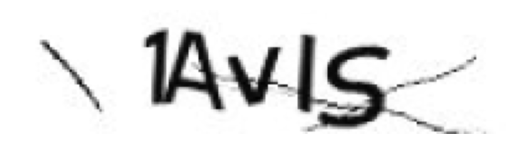


Wrong prediction: 77x5[UNK]
Actual text: A9XFs


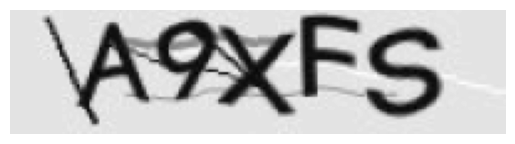


Wrong prediction: 7577[UNK]
Actual text: FF5FZ


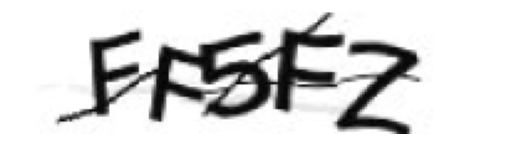


Wrong prediction: 77f7f
Actual text: QV1YE


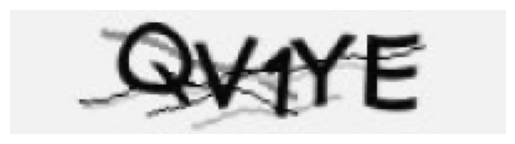


Wrong prediction: 7[UNK][UNK][UNK][UNK]
Actual text: UzUvi


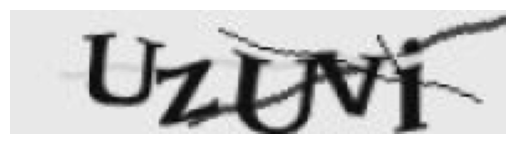


Wrong prediction: 7ff[UNK][UNK]
Actual text: VZFA3


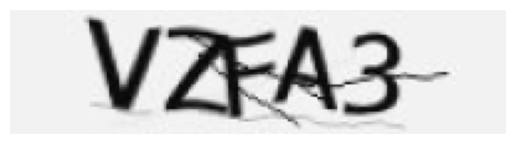


Wrong prediction: 5x[UNK][UNK][UNK]
Actual text: zzXiN


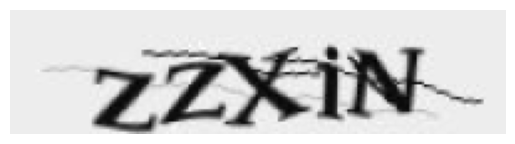

In [ ]:
img_format = 'jpg'
archive_path = 'drive/My Drive/new_samples'
images = sorted(list(map(str, list(Path(archive_path).glob('*' + img_format)))))
labels = [img.split(os.path.sep)[-1].split('.' + img_format)[0] for img in images]
wrong_predictions = []

for i in range(len(images)):
    image = np.expand_dims(encode_img(str(images[i])), axis=0)
    predicted_value = decode_batch_predictions(prediction_model.predict(image))[0]
    wrong_predictions.append((predicted_value, labels[i]))

assert len(images) == len(wrong_predictions)
plot_wrong_predictions(archive_path, img_format, wrong_predictions)